# DBMI Related Software Landscape Analysis

This notebook explores the existing software landscape of DBMI or DBMI related software projects (including collaborations and general CU Anschutz ecosystem).

## Setup

Set an environment variable named `LANDSCAPE_ANALYSIS_GH_TOKEN` to a [GitHub access token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens). E.g.: `export LANDSCAPE_ANALYSIS_GH_TOKEN=token_here`

In [13]:
import json
import os
import pathlib
import statistics
import subprocess
from datetime import datetime, timedelta
from typing import Dict, Optional, Union

import awkward as ak
import duckdb
import github
import numpy as np
import pandas as pd
import plotly.colors as pc
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import pytz
import requests
from box import Box
from github import Auth, Github, Repository

# set predefined path for data
data_dir = "../data"

# set github authorization and client
github_client = Github(
    auth=Auth.Token(os.environ.get("LANDSCAPE_ANALYSIS_GH_TOKEN")), per_page=100
)

# set plotly default theme
pio.templates.default = "simple_white"

# define a color sequence to use
color_seq = pc.qualitative.Dark2

In [2]:
# gather org data
org_names = Box.from_yaml(
    filename=f"{data_dir}/software-landscape/github-orgs.yaml"
).organizations

# show how many orgs we need to gather data from
len(org_names)

36

In [3]:
def get_github_org_or_user(
    name: str,
) -> Union[github.NamedUser.NamedUser, github.Organization.Organization]:
    """
    Convenience function to gather pygithub orgs or users similarly
    using only a name as a reference point to simplify data gathering.
    """

    try:
        # attempt to find github org
        return github_client.get_organization(name)
    except github.UnknownObjectException:
        # if we failed to find the org, try as a user instead
        return github_client.get_user(name)


def safe_get_readme(repo: github.Repository.Repository) -> Optional[str]:
    """
    Safely retrieve GitHub repo readme data as a string,
    returning a None where no readme is found.
    """

    try:
        repo.get_readme().content
    except github.UnknownObjectException:
        return None


def safe_detect_license(repo: github.Repository.Repository) -> Optional[str]:
    """
    Safely retrieve detect the license type ID,
    returning a None where no readme is found
    """

    try:
        return repo.get_license().license.spdx_id
    except:
        return None


def get_github_repo_sbom(full_name: str) -> Optional[Dict[str, str]]:
    """
    Gathers GitHub Software Bill of Materials (SBOM) data
    given a full_name (org/repo_name).

    See here for more information:
    https://docs.github.com/en/rest/dependency-graph/sboms
    """

    try:
        response = requests.get(
            f"https://api.github.com/repos/{full_name}/dependency-graph/sbom",
            headers={
                "Accept": "application/vnd.github+json",
                "Authorization": f"Bearer {os.environ.get('LANDSCAPE_ANALYSIS_GH_TOKEN')}",
                "X-GitHub-Api-Version": "2022-11-28",
            },
            timeout=10,
        )
        response.raise_for_status()  # Raise an exception for HTTP errors

        # return the result json
        return response.json()

    except requests.exceptions.RequestException as err:
        print("Experienced SBOM error: ", err)
        return None

In [4]:
# gather targeted data from GitHub
github_metrics = [
    {
        "GitHub Org Name": org_name,
        "Repo Name": repo.name,
        "GitHub Repo Full Name": repo.full_name,
        "GitHub Repository ID": repo.id,
        "Repository Size (KB)": repo.size,
        "GitHub Repo Archived": repo.archived,
        "GitHub Repo Created Month": repo.created_at.strftime("%Y-%m-%d"),
        "GitHub Stars": repo.stargazers_count,
        "GitHub Network Count": repo.network_count,
        "GitHub Forks": repo.forks_count,
        "GitHub Subscribers": repo.subscribers_count,
        "GitHub Open Issues": repo.get_issues(state="open").totalCount,
        "GitHub Contributors": repo.get_contributors().totalCount,
        "GitHub License Type": safe_detect_license(repo),
        "GitHub Topics": repo.topics,
        "GitHub Description": repo.description,
        "GitHub Readme": safe_get_readme(repo),
        "GitHub Detected Languages": repo.get_languages(),
        "GitHub Repo SBOM": get_github_repo_sbom(repo.full_name),
    }
    # make a request for github org data with pygithub
    for org_name, repo in [
        (
            org_name,
            repo,
        )
        for org_name in org_names
        for repo in get_github_org_or_user(org_name).get_repos()
    ]
]
ak.Array(github_metrics)

Request GET /repos/brentp/primer failed with 403: Forbidden
Setting next backoff to 282.146736s


<Array [{'GitHub Org Name': ..., ...}, ...] type='1099 * {"GitHub Org Name"...'>

In [ ]:
# gather sbom data from GitHub
github_metrics = [
    dict({})
    # make a request for github org data with pygithub
    for existing_data, repo in [
        (existing_data, github_client.get_repo(repo["GitHub Repo Full Name"]))
        for existing_data in github_metrics
    ]
]
ak.Array(github_metrics)

In [5]:
df_github_metrics = pd.DataFrame(github_metrics)
df_github_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099 entries, 0 to 1098
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   GitHub Org Name            1099 non-null   object
 1   Repo Name                  1099 non-null   object
 2   GitHub Repo Full Name      1099 non-null   object
 3   GitHub Repository ID       1099 non-null   int64 
 4   Repository Size (KB)       1099 non-null   int64 
 5   GitHub Repo Archived       1099 non-null   bool  
 6   GitHub Repo Created Month  1099 non-null   object
 7   GitHub Stars               1099 non-null   int64 
 8   GitHub Network Count       1099 non-null   int64 
 9   GitHub Forks               1099 non-null   int64 
 10  GitHub Subscribers         1099 non-null   int64 
 11  GitHub Open Issues         1099 non-null   int64 
 12  GitHub Contributors        1099 non-null   int64 
 13  GitHub License Type        633 non-null    object
 14  GitHub T

In [6]:
# Function to find the top language for each row
def find_top_language(languages):
    if isinstance(languages, dict):
        non_empty_languages = {
            key: value for key, value in languages.items() if value is not None
        }
        if non_empty_languages:
            return max(non_empty_languages, key=non_empty_languages.get)
    return None


# gather the number of lines of code
df_github_metrics["Total lines of GitHub detected code"] = (
    df_github_metrics["GitHub Detected Languages"]
    .dropna()
    .apply(lambda x: sum(value if value is not None else 0 for value in x.values()))
)

# Apply the function to the "GitHub Detected Languages" column and create a new column "Primary programming language"
df_github_metrics["Primary language"] = df_github_metrics[
    "GitHub Detected Languages"
].apply(find_top_language)
df_github_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099 entries, 0 to 1098
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   GitHub Org Name                      1099 non-null   object
 1   Repo Name                            1099 non-null   object
 2   GitHub Repo Full Name                1099 non-null   object
 3   GitHub Repository ID                 1099 non-null   int64 
 4   Repository Size (KB)                 1099 non-null   int64 
 5   GitHub Repo Archived                 1099 non-null   bool  
 6   GitHub Repo Created Month            1099 non-null   object
 7   GitHub Stars                         1099 non-null   int64 
 8   GitHub Network Count                 1099 non-null   int64 
 9   GitHub Forks                         1099 non-null   int64 
 10  GitHub Subscribers                   1099 non-null   int64 
 11  GitHub Open Issues                   1099 n

In [7]:
# prep for creating an hbar chart for primary languages
grouped_data = (
    df_github_metrics.groupby(["Primary language"]).size().reset_index(name="Count")
)

# Group by "Primary programming language" and calculate the sum of counts for each programming language
programming_language_counts = (
    grouped_data.groupby("Primary language")["Count"].sum().reset_index()
)

# Sort programming languages by the sum of counts in descending order
programming_language_counts = programming_language_counts.sort_values(
    by="Count", ascending=False
)
programming_language_counts

,Primary language,Count
29,Python,222
17,Jupyter Notebook,138
30,R,133
12,HTML,95
14,Java,47
1,C,46
9,Go,38
38,Shell,32
23,Nim,31
15,JavaScript,28


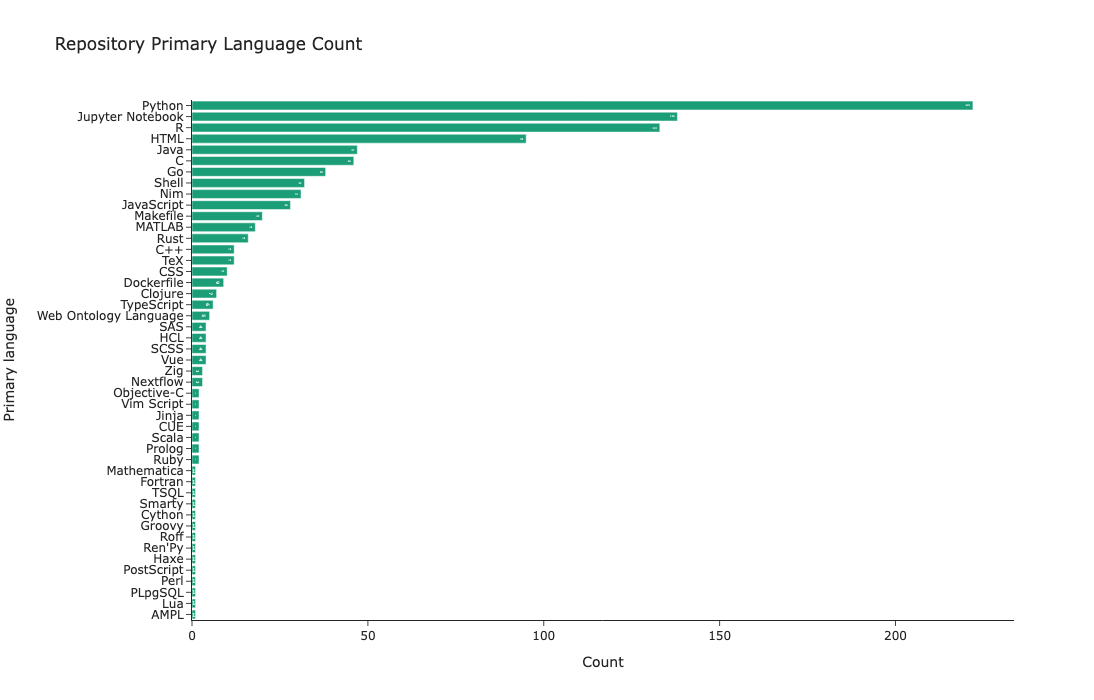

In [19]:
# Create a horizontal bar chart for primary language counts
fig_languages = px.bar(
    data_frame=grouped_data.sort_values(by="Count"),
    title=f"Repository Primary Language Count",
    y="Primary language",
    x="Count",
    color_discrete_sequence=[color_seq[0]],
    text="Count",
    orientation="h",
    width=1200,
    height=700,
)

# Customize layout to display count labels properly
fig_languages.update_traces(
    texttemplate="%{text}",
    textposition="inside",
)
fig_languages.update_layout(
    # ensure all y axis labels appear
    yaxis=dict(
        tickmode="array",
        tickvals=programming_language_counts["Primary language"].tolist(),
        ticktext=programming_language_counts["Primary language"].tolist(),
    ),
)

fig_languages.write_image("images/software-landscape-primary-language-counts.png")
fig_languages.show()

In [10]:
# gather total lines of code for all repos by language
total_language_line_counts = [
    {
        "language": language,
        "line_count": ak.sum(
            ak.Array(github_metrics)["GitHub Detected Languages"][language]
        ),
    }
    for language in ak.Array(github_metrics)["GitHub Detected Languages"].fields
]

df_total_language_line_counts = pd.DataFrame.from_records(
    total_language_line_counts
).sort_values(by="line_count")

df_total_language_line_counts

,language,line_count
90,Procfile,59
10,Mercury,60
70,Crystal,227
58,Cap'n Proto,311
67,Gnuplot,353
...,...,...
11,Python,109551376
14,C++,121451215
76,Web Ontology Language,206909487
15,HTML,799925077


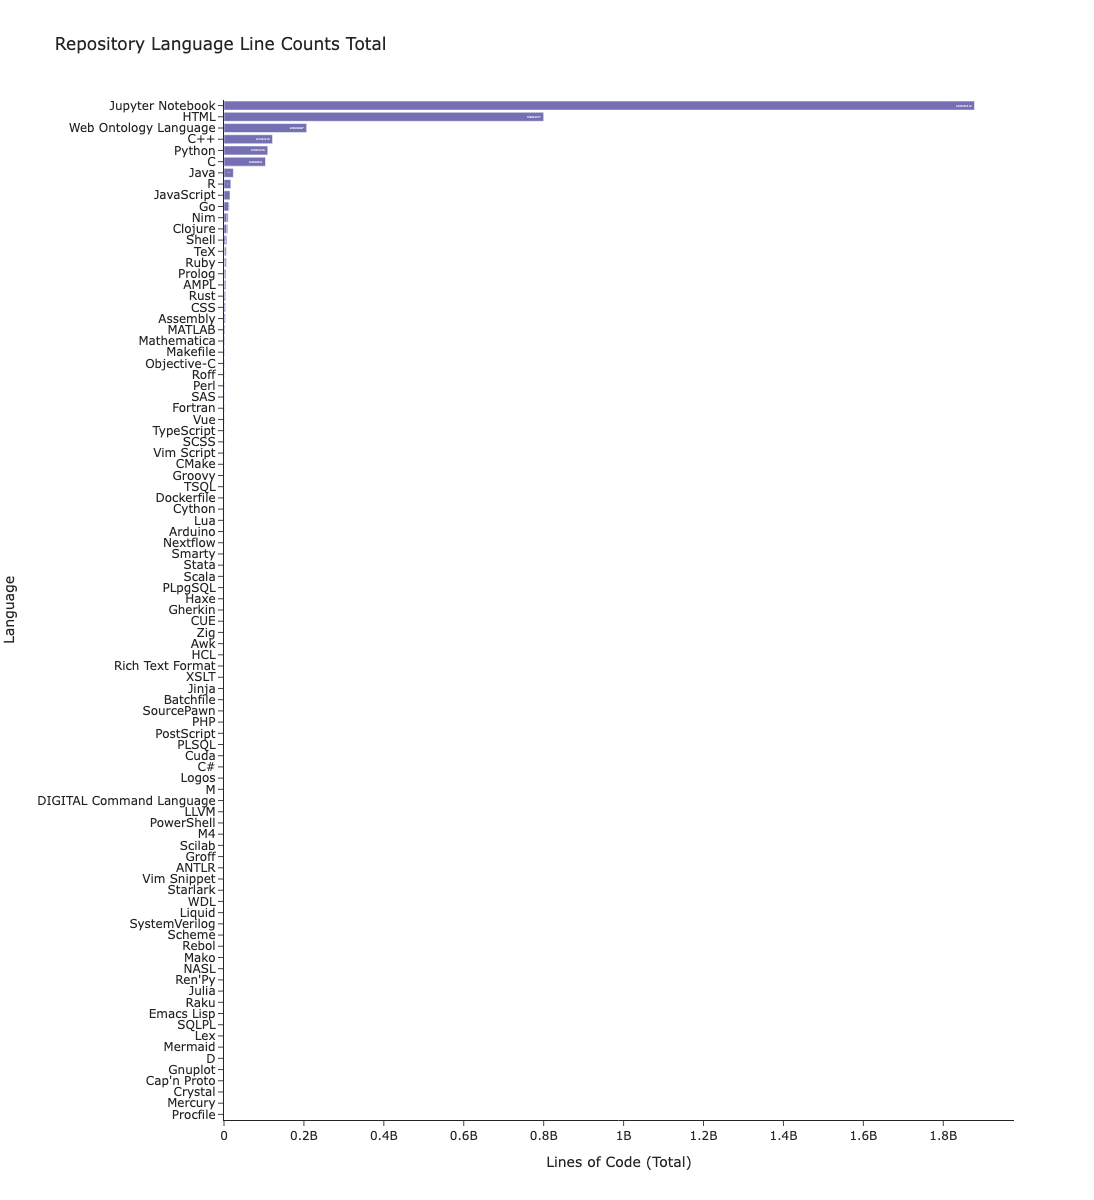

In [12]:
# Create a horizontal bar chart for language line count totals
fig_languages = px.bar(
    data_frame=df_total_language_line_counts.sort_values(by="line_count"),
    title=f"Repository Language Line Counts Total",
    y="language",
    x="line_count",
    color_discrete_sequence=[color_seq[2]],
    text="line_count",
    orientation="h",
    width=1200,
    height=1200,
)

# Customize layout to display count labels properly
fig_languages.update_traces(
    texttemplate="%{text}",
    textposition="inside",
)
fig_languages.update_layout(
    xaxis_title="Lines of Code (Total)",
    yaxis_title="Language",
    # ensure all y axis labels appear
    yaxis=dict(
        tickmode="array",
        tickvals=df_total_language_line_counts["language"].tolist(),
        ticktext=df_total_language_line_counts["language"].tolist(),
    ),
)

fig_languages.write_image("images/software-landscape-language-line-counts-total.png")
fig_languages.show()

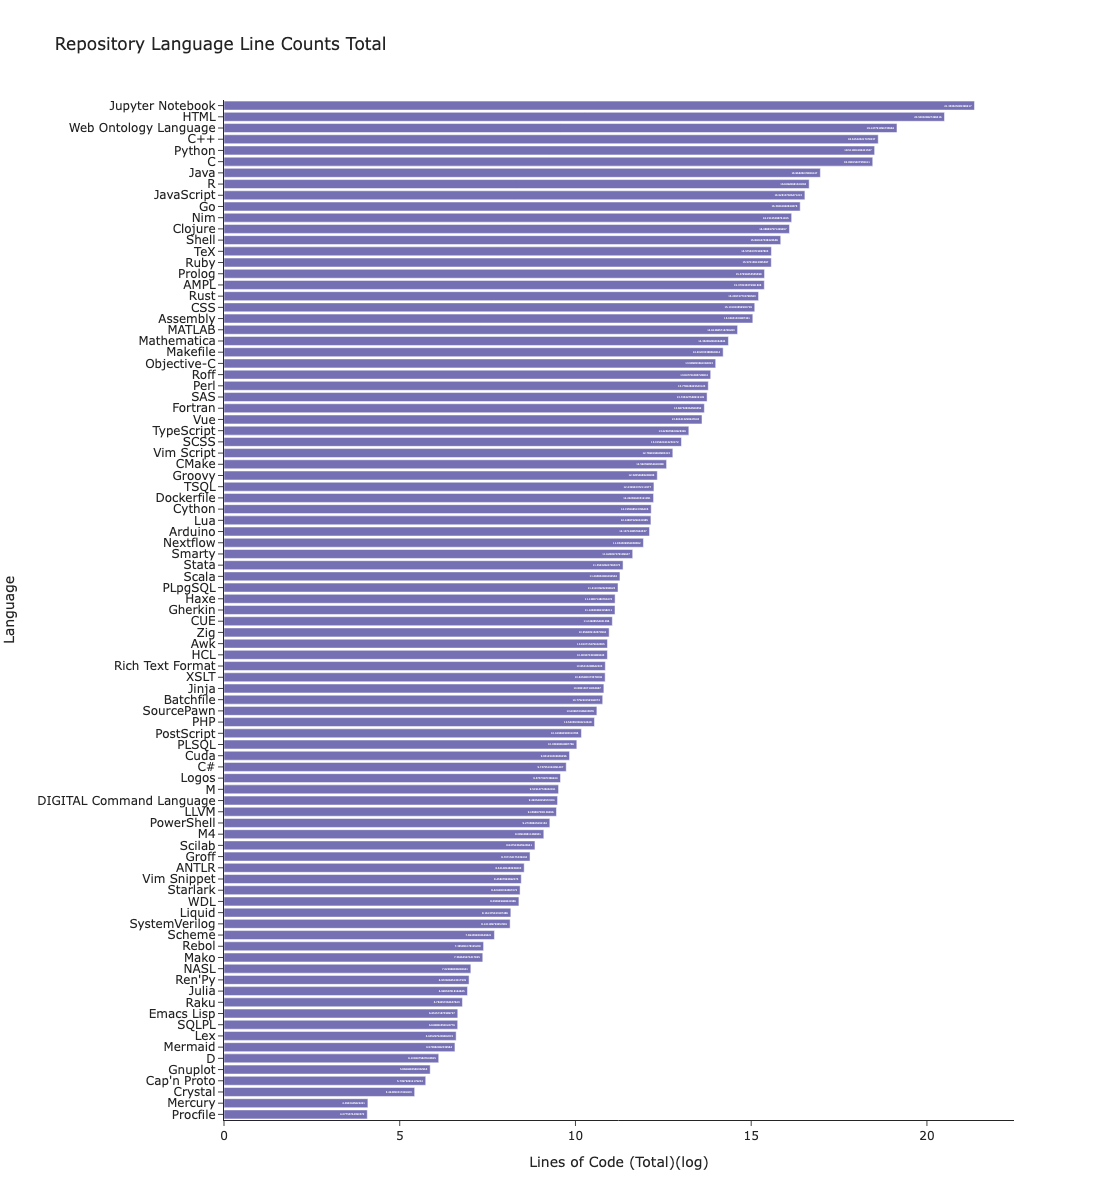

In [14]:
df_total_language_line_counts["line_count_log"] = np.log(
    df_total_language_line_counts["line_count"]
)

# Create a horizontal bar chart for language line count totals
fig_languages = px.bar(
    data_frame=df_total_language_line_counts.sort_values(by="line_count_log"),
    title=f"Repository Language Line Counts Total",
    y="language",
    x="line_count_log",
    color_discrete_sequence=[color_seq[2]],
    text="line_count_log",
    orientation="h",
    width=1200,
    height=1200,
)

# Customize layout to display count labels properly
fig_languages.update_traces(
    texttemplate="%{text}",
    textposition="inside",
)
fig_languages.update_layout(
    xaxis_title="Lines of Code (Total)(log)",
    yaxis_title="Language",
    # ensure all y axis labels appear
    yaxis=dict(
        tickmode="array",
        tickvals=df_total_language_line_counts["language"].tolist(),
        ticktext=df_total_language_line_counts["language"].tolist(),
    ),
)

fig_languages.write_image(
    "images/software-landscape-language-line-counts-total-log.png"
)
fig_languages.show()